In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
# https://github.com/leondgarse/keras_efficientnet_v2
!pip install -U keras-efficientnet-v2

In [ ]:
import keras_efficientnet_v2
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime

In [ ]:
data_dir = "/content/drive/MyDrive/food"

batch_size = 128
imgSize = 224

splitRate = 0.2

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, seed=123, subset="training", validation_split=splitRate,
  image_size=(imgSize, imgSize), batch_size=batch_size
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, seed=123, subset="validation", validation_split=splitRate,
  image_size=(imgSize, imgSize), batch_size=batch_size
)

classNum = len(train_ds.class_names)
print(train_ds.class_names)

In [ ]:
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
  ]
)

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(imgSize, imgSize),
  tf.keras.layers.Rescaling(1./127.5, offset=-1)
])

In [ ]:
expendRound = 2
temp_ds = train_ds
for i in range(expendRound):
    train_ds = train_ds.concatenate(temp_ds)

train_ds = train_ds.map(lambda image,label:(data_augmentation(image),label))
train_ds = train_ds.map(lambda image,label:(resize_and_rescale(image),label))

valid_ds = valid_ds.map(lambda image,label:(resize_and_rescale(image),label))

In [ ]:
baseModel = keras_efficientnet_v2.EfficientNetV1B0(pretrained="noisy_student", num_classes=classNum, drop_connect_rate=0.4)

baseModel.trainable = True
print("Layers count", len(baseModel.layers))

fine_tune_at = int( len(baseModel.layers) * 0.2) # 20
for layer in baseModel.layers[:fine_tune_at]:
  layer.trainable = False
  
epochsRound = 12
base_learning_rate = 0.0001

checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

baseModel.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = baseModel.fit(train_ds, epochs=epochsRound, validation_data=valid_ds, callbacks=[model_checkpoint_callback] )

now = datetime.now()
current_time = now.strftime("%b-%d-%Y_%H:%M:%S")

# for colab
srt = "/content/drive/MyDrive/savedModel/" + "efficientnetV1B0" + current_time + ".h5"

# for windows / mac
#srt = "efficientnetV1B0" + current_time + ".h5"

baseModel.load_weights(checkpoint_filepath)

test_loss, test_acc = baseModel.evaluate(valid_ds, verbose=2)
print(test_acc)

baseModel.save(srt)

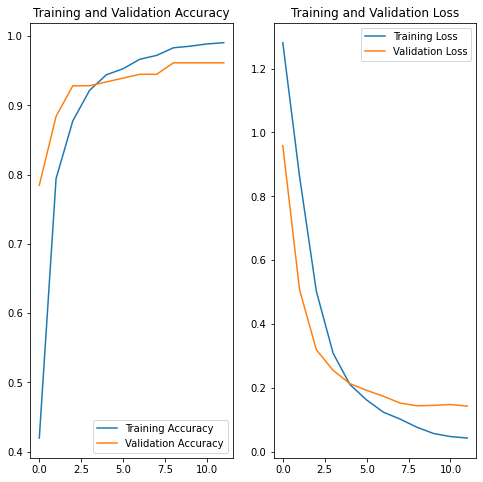

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochsRound)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## predict with model

In [ ]:
imgPath = 'your/image/location'
model = tf.keras.models.load_model('my_model.h5')
label = ["your" , "label", "regarding" , "the" , "training" , "label", "priority"]

image = tf.keras.preprocessing.image.load_img(
    imgPath, color_mode="rgb", target_size=(224,224)
)
    
input_arr = ( tf.keras.preprocessing.image.img_to_array(image) / 127.5) - 1
input_arr = np.array([input_arr])

prediction = model.predict(input_arr)
print(prediction)

maxIndex = np.argmax(prediction)
print(label[maxIndex])

# References  

1. Keras EfficientNetV2:  
https://github.com/leondgarse/keras_efficientnet_v2  
2. Transfer learning and fine-tuning  
https://www.tensorflow.org/tutorials/images/transfer_learning?hl=zh-tw  
